# Dataquest Guided Project: Predicting Heart Disease

**Purpose:** In this scenario, I am working for an R&D company that provides healthcare solutions. The company has provided anonymized data from several hospitals detailing patients' personal and medical history and whether or not they have experienced heart disease. I will be tasked with identifying which patient features best predict heart disease. The dataset can be accessed [here](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction).

## Import Libraries

In [1]:
import pandas as pd
import statistics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Preview Data

In [2]:
#Load data
hdp = pd.read_csv("heart.csv")

#View first five rows
print("Here are the first 5 rows of the dataset:")
hdp.head()

#Get num features and observations
print(f'There are {hdp.shape[0]} observations and {hdp.shape[1]} features.')

Here are the first 5 rows of the dataset:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


There are 918 observations and 12 features.


Here are the features:
1. `Age`: age of the patient [years]
2.`Sex`: sex of the patient [M: Male, F: Female]
3. `ChestPainType`: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. `RestingBP`: resting blood pressure [mm Hg]
5. `Cholesterol`: serum cholesterol [mm/dl]
6. `FastingBS`: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. `RestingECG`: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]
9. `ExerciseAngina`: exercise-induced angina [Y: Yes, N: No]
10. `Oldpeak`: oldpeak = ST [Numeric value measured in depression]
11. `ST_Slope`: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. `HeartDisease`: output class [1: heart disease, 0: Normal]

## Data Exploration

In [3]:
hdp.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

I have a mix of categorical and numeric variable. I'll now get some descriptive statistics for the numeric columns. Note that `FastingBS` and `HeartDisease` are numeric columns, but since there values are only 0 and 1, they will be used as categorical variables in practice.

In [4]:
hdp.describe()
hdp.isna().sum()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

* There aren't any missing data values, but some of the minimum values indicate we might be actually missing data/the patient did not have certain features recorded for them:
    * The minimum should not be 0 for resting blood pressure or cholesterol.
    * Cholesterol distribution is left skewed (median is higher than mean); perhaps these 0s will explain that.
* The average patient age is 53.5 (ages ranging from 28 to 77) and 55% of patients have experience with heart disease.

Now I'll get some visualizations for the categorical variables.

### Percent Breakdown of Categorical Variables
* 55% of patients have experience with heart disease.
* About 75% of our patients are male.
* About 75% of our patients do not have a fasting blood sugar.
* Most patients do not have Exercise Angina.
* Most patients have ASY type chest pain.
* Most patients have a normal resting ECG.
* Half of patients have a flat st slope; 40% have an upward st slope.

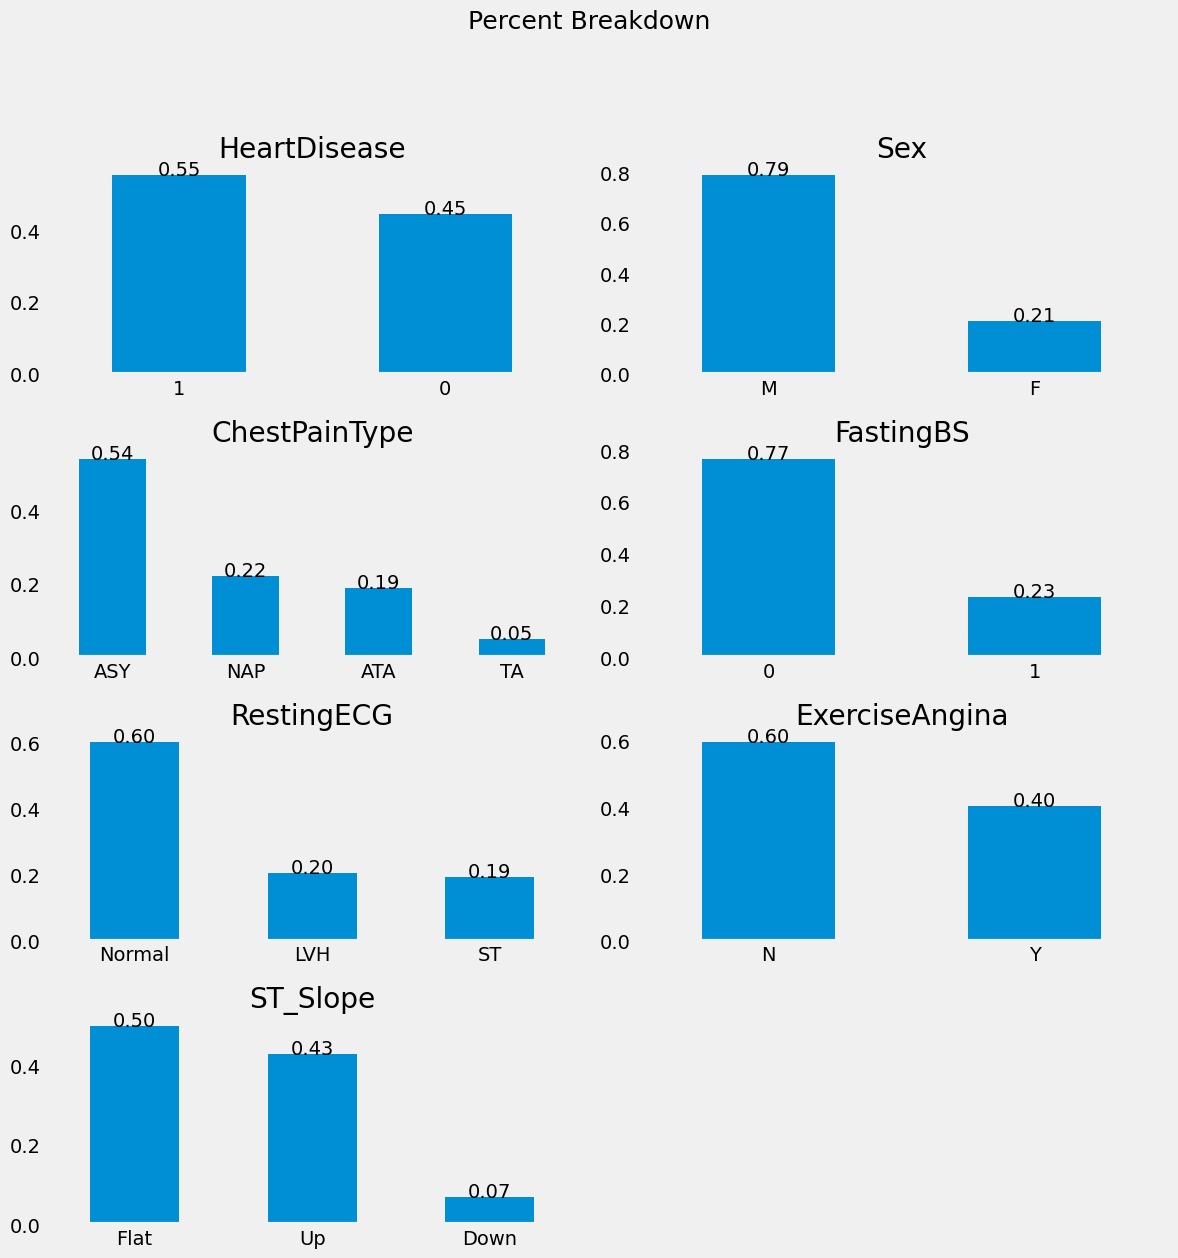

In [5]:
#get categorical columns
cat_cols = ['HeartDisease', 'Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# create grid of plots
num_rows = 4
num_cols = 2
fig = plt.figure(figsize=(12, 12))
fig.suptitle("Percent Breakdown", fontsize=18, y=1.05)
# Loop through columns and create a subplot for each
for i, col in enumerate(cat_cols):
    # Create subplot
    ax = fig.add_subplot(num_rows, num_cols, i+1)
    
    # Create a bar plot for the current column
    counts = hdp[col].value_counts(normalize=True)
    counts.plot(kind='bar', ax=ax)
    
    # Rotate axis labels
    ax.tick_params(axis='x', labelrotation=0)
    # Add value labels to each bar
    for j, val in enumerate(counts):
        ax.text(j, val, f"{val:.2f}", ha='center')
    
    # Set the title for the subplot
    ax.set_title(f"{col}")
    ax.grid(False)
   
# Adjust spacing
fig.tight_layout();



### Heart Disease Prevalence by Categorical Variables
* Men have a higher rate of heart disease compared to women.
* ASY ChestPainType is most associated with heart disease, followed by TA, NAP, and finally ATA.
* Patients with a recorded fasting blood sugar are more likely to have heart disease. (Are patients suspected of having heart disease the ones who receive this test?)
* ST RestingECG is marginally more associated with heart disease compared to normal and LVH.
* ExerciseAngina is highly associated with heart disease.
* Flat and downward ST_slopes are highly associated with heart disease.

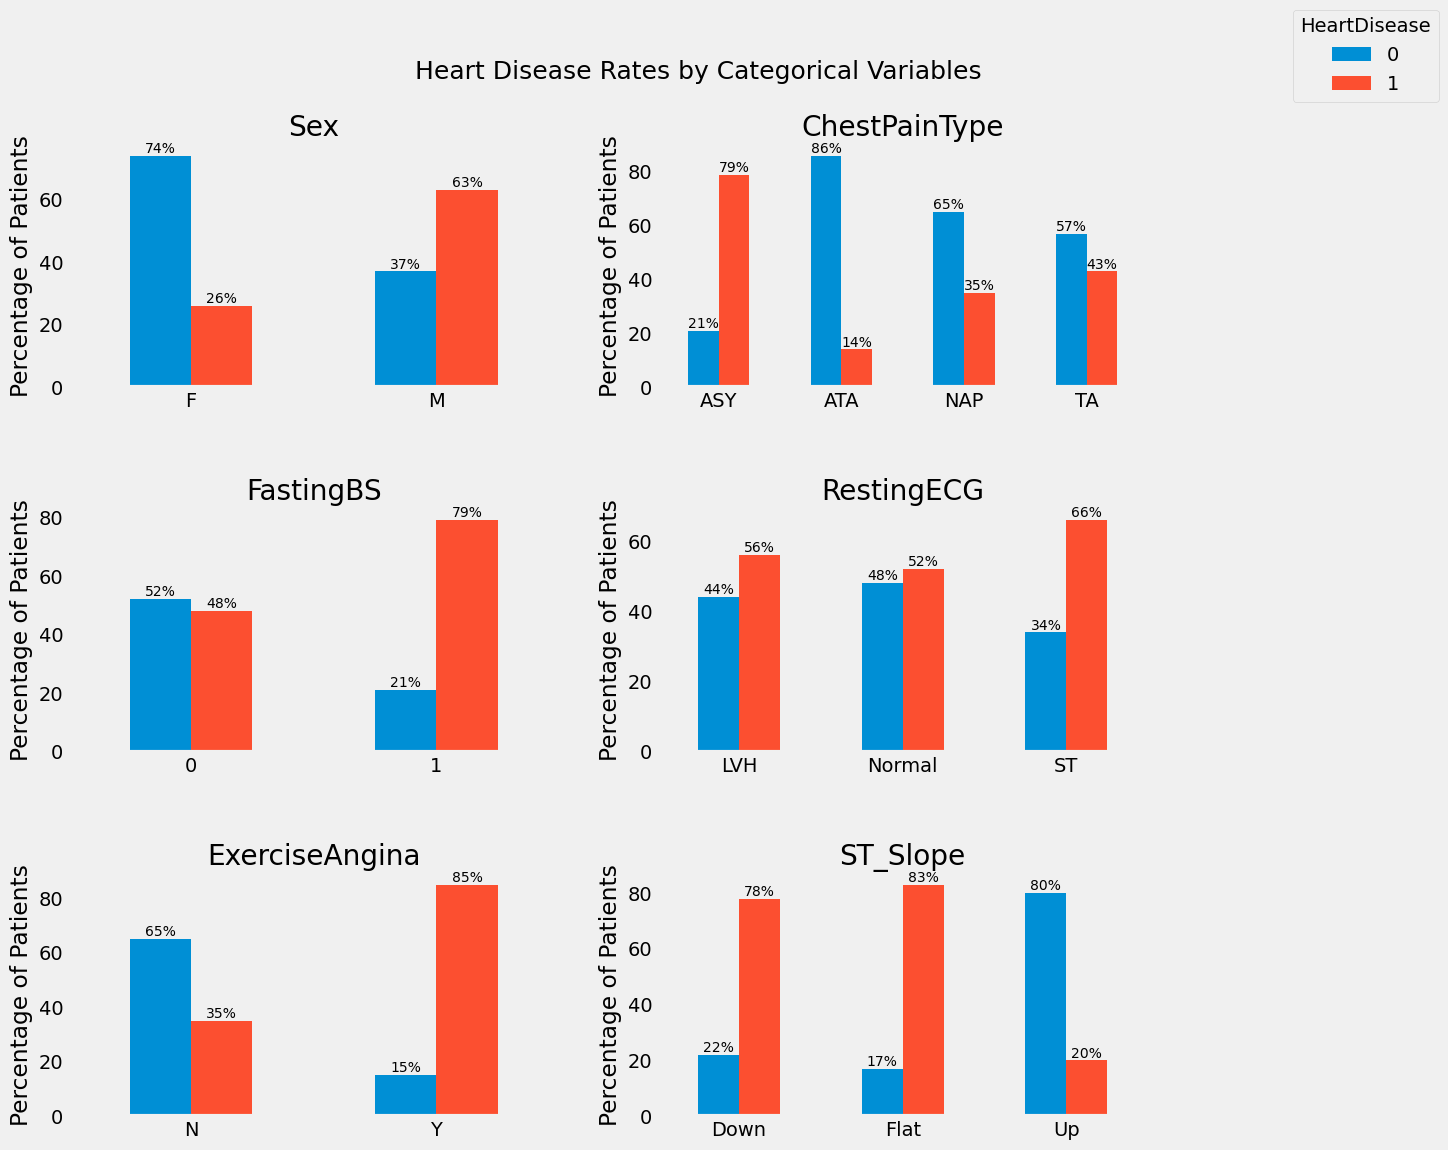

In [6]:
cat_cols2 = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Heart Disease Rates by Categorical Variables", fontsize=18, y=0.95)
# create empty list to store labels for legend
labels = []

# loop through columns and axes
for col, ax in zip(cat_cols2, axs.ravel()):
    # filter df for ticker and plot on specified axes
    # Group by variables and get proportions
    grouped_df = hdp.groupby([col, 'HeartDisease']).size().groupby(level=0).apply(lambda x: round(x / x.sum()*100, 0)).reset_index(name='proportion')

    # Pivot table to format data for plotting
    pivot_df = grouped_df.pivot(index= col, columns='HeartDisease', values='proportion')

    # Plot bar chart
    pivot_df.plot(kind='bar', rot=0, ax=ax)
    
    # Add value labels to bars
    for p in ax.containers:
        ax.bar_label(p, label_type='edge', labels=[f"{int(round(height))}%" for height in p.datavalues], fontsize=10)

    # Set x and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('Percentage of Patients')
    
    # Add extra room for legend to the right of the bars
    fig.subplots_adjust(right=0.8)

    # Append the labels for this subplot to the list
    labels.append(pivot_df.columns.to_list())
    # Remove legend
    ax.legend().set_visible(False)

    # Set the title for the subplot
    ax.set_title(f"{col}")
    ax.grid(False)
    
# Flatten the list of labels and remove duplicates
flat_labels = list(set([item for sublist in labels for item in sublist]))

# Show legend at the top right of the figure
fig.legend(labels=flat_labels, loc='upper right', title='HeartDisease')

plt.show();


### Distribution of Heart Disease by Categorical Variables

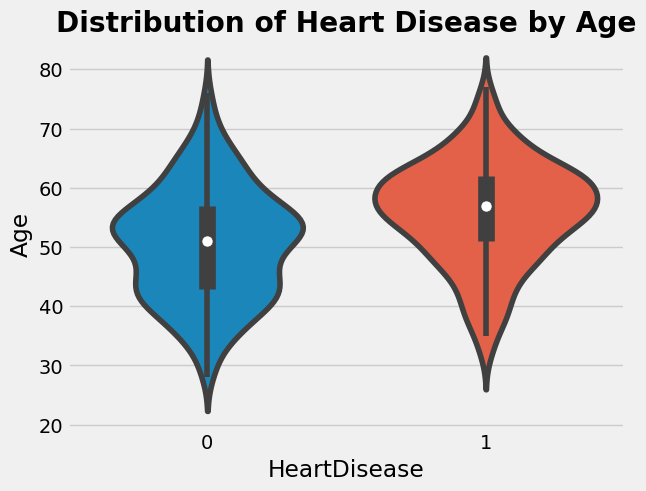

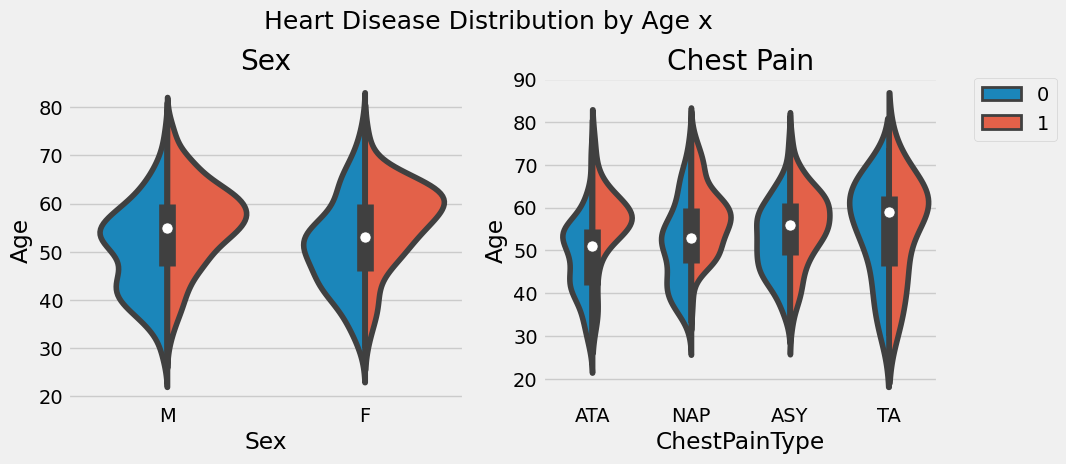

In [7]:
#Heart disease x age
sns.violinplot(data= hdp, x = "HeartDisease", y = "Age", split= True)
plt.title('Distribution of Heart Disease by Age', weight= 'bold')
plt.show();

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.suptitle("Heart Disease Distribution by Age x", fontsize=18, y=1.05)
#heart disease x sex x age
sns.violinplot(ax=axes[0], data= hdp, x= "Sex", y= "Age", hue="HeartDisease", split=True)
axes[0].set_title('Sex')
axes[0].legend().set_visible(False)

#heart diease x cheset pain x age
sns.violinplot(ax = axes[1], data= hdp, x= "ChestPainType", y= "Age", hue="HeartDisease", split=True, legend_out = True)
axes[1].set_title('Chest Pain')
plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right', borderaxespad=0)

plt.show();



## Data Cleaning
I'll start by reviewing rows that have 0s for columns that don't make sense.

In [8]:
print(f"{hdp[hdp['RestingBP'] == 0].shape[0]} row has a 0 for Resting BP.")
print(f"{hdp[hdp['Cholesterol'] == 0].shape[0]} rows have a 0 for Cholesterol.")

1 row has a 0 for Resting BP.
172 rows have a 0 for Cholesterol.


Since there's only one 0 for Resting BP, I will remove that observation.

In [9]:
# create copy of dp
hdp_clean = hdp.copy()

hdp_clean.drop(hdp_clean[hdp_clean['RestingBP'] == 0].index, inplace = True)
hdp_clean[hdp_clean['RestingBP'] == 0].shape[0]

0

For Cholesterol, I will impute the missing values using the median value of the column based on heart disease status.
First, let's view the distribution of Cholesterol before imputing missing values.

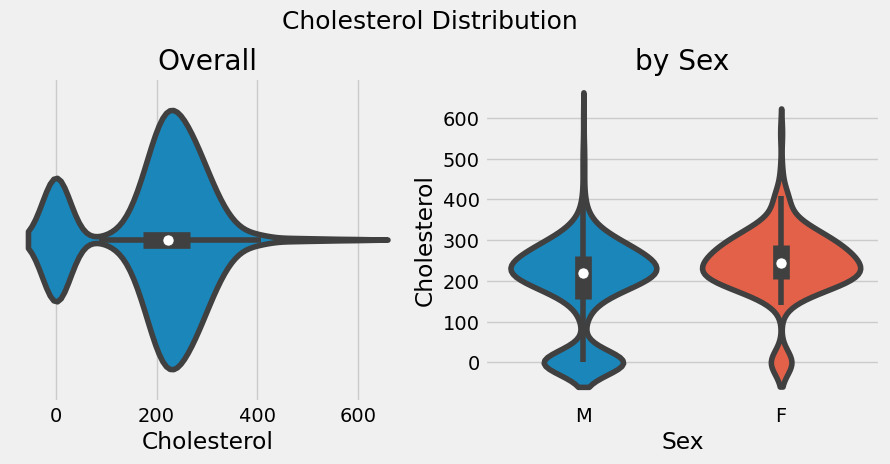

In [10]:
#Cholesterol x Sex
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.suptitle("Cholesterol Distribution", fontsize=18, y=1.05)
#cholesterol
sns.violinplot(ax=axes[0], data= hdp, x= "Cholesterol")
axes[0].set_title('Overall')

#Cholesterol x Sex
sns.violinplot(ax = axes[1], data= hdp, x = "Sex", y = "Cholesterol", split= True)
axes[1].set_title('by Sex')

plt.show();

I'll impute missing values using the median for each sex and heart disease status.

In [11]:
# Impute 0 values in with median grouped by HeartDisease
hdp_clean['Cholesterol'] = hdp_clean.groupby(['Sex', 'HeartDisease'])['Cholesterol'].apply(lambda x: x.replace(0, x.median()))
hdp_clean[hdp_clean['Cholesterol'] == 0].shape[0]

0

Let's review the distribution of Cholesterol after imputation.

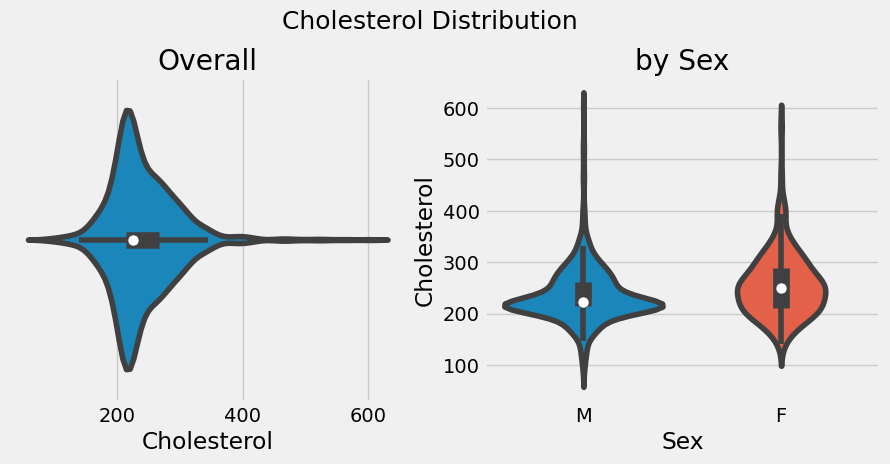

In [12]:
#Cholesterol x Sex
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
fig.suptitle("Cholesterol Distribution", fontsize=18, y=1.05)
#cholesterol
sns.violinplot(ax=axes[0], data= hdp_clean, x= "Cholesterol")
axes[0].set_title('Overall')

#Cholesterol x Sex
sns.violinplot(ax = axes[1], data= hdp_clean, x = "Sex", y = "Cholesterol", split= True)
axes[1].set_title('by Sex')

plt.show();

## Feature Selection

Based on the exploratory data analysis, I'll use `Age`, `Sex`, `Cholesterol`, `ExerciseAngina`, `ChestPainType`, and `ST_Slope`. `FastingBS` will not be used because the vasted majority of patients have a 0 for that field. `RestingECG` will not be used because a majority of patients have a normal value and across `RestingECG` values we see similar rates of heart disease.

In [13]:
#Create dummy variables from categorical variables
hdp_clean = pd.get_dummies(hdp_clean, columns= ['Sex', 'ExerciseAngina', 'ChestPainType', 'ST_Slope'], drop_first=True)


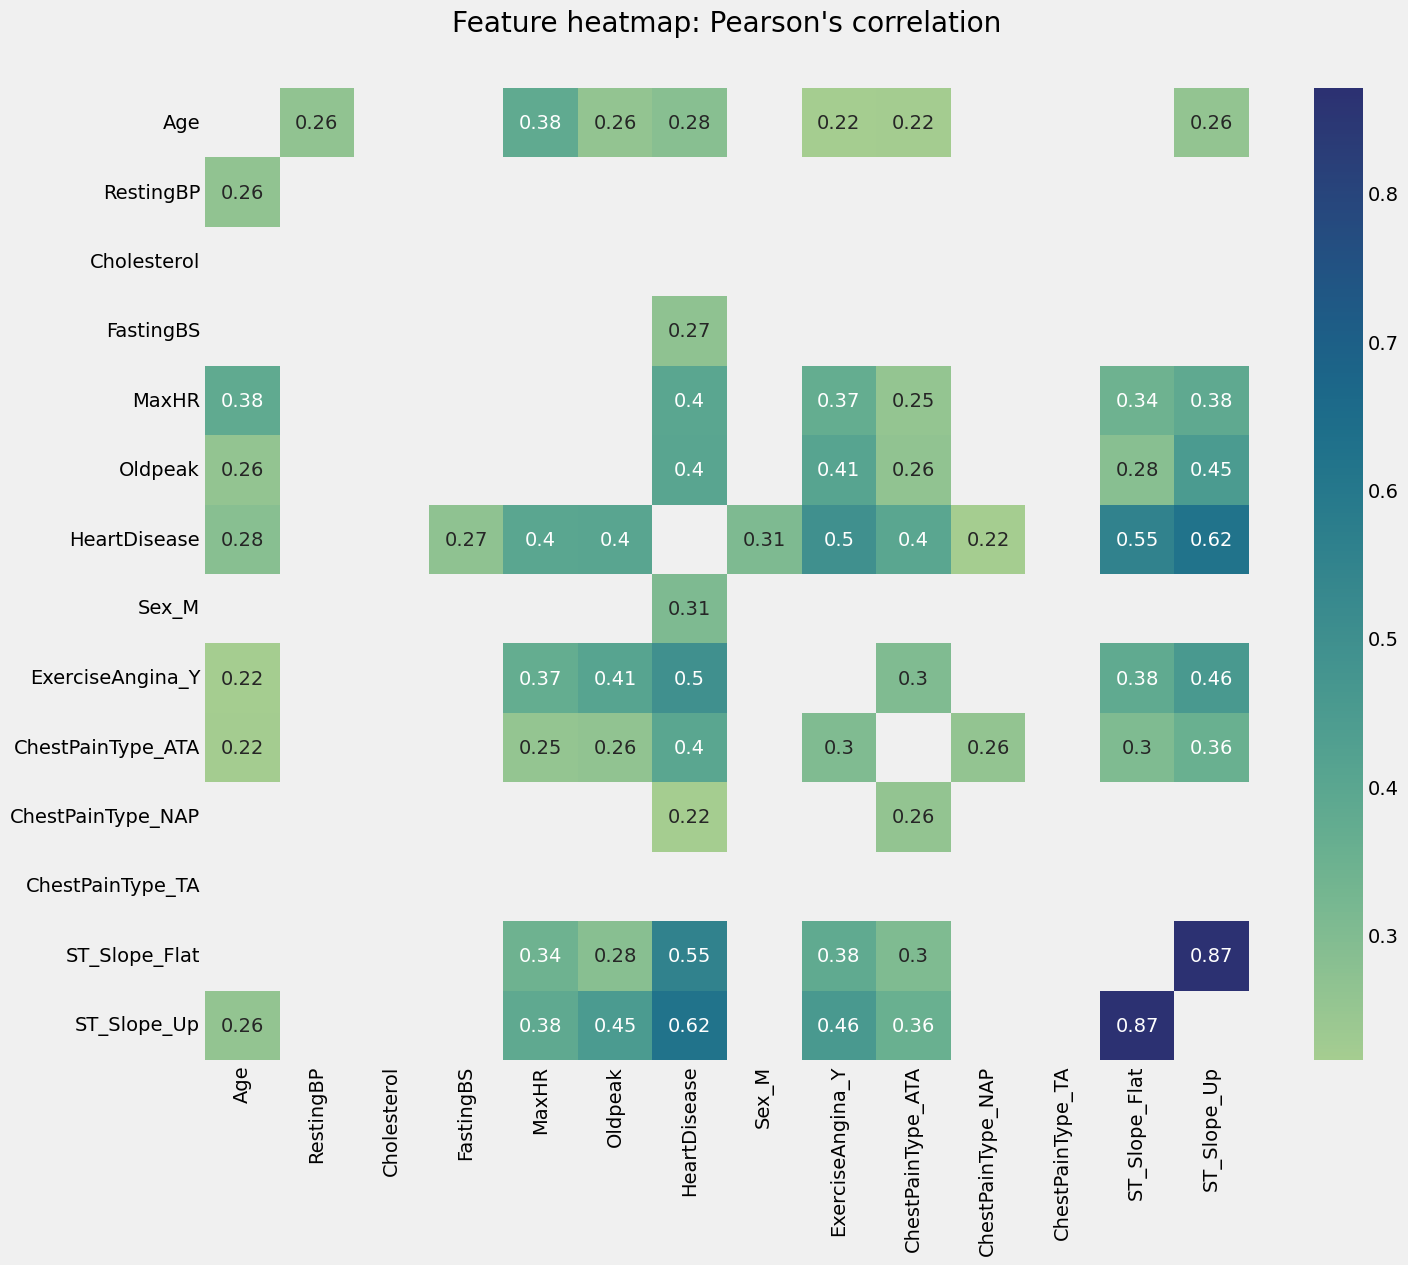

In [14]:
#create pearson correlation heatmap of features
corrs = abs(hdp_clean.corr())

#only show corrs between .2 and 1 for readability (corr = 1 is just self correlation)
plt.figure(figsize=(15,12))
sns.heatmap(corrs[(corrs>0.2)&(corrs<1)], cmap='crest', annot=True)
plt.title("Feature heatmap: Pearson's correlation", y = 1.05);

So far, the following seem promising as features:
* `MaxHR`
* `Oldpeak`
* `ExerciseAngina_Y`
* `ChestPainType_ATA`
* `Sex_M`
* `ST_Slope_Flat`
* `ST_Slope_Up`

I'll also look at the squared pearson values to see if I find the same 7 features; this helps capture nonlinear relationships.

In [15]:
#create pearson correlation heatmap of features
corrs_sq = hdp_clean.corr()**2
top_7 = corrs_sq['HeartDisease'].sort_values(ascending=False)[1:8]
top_7


ST_Slope_Up          0.386688
ST_Slope_Flat        0.306584
ExerciseAngina_Y     0.245510
Oldpeak              0.162924
ChestPainType_ATA    0.161346
MaxHR                0.161130
Sex_M                0.093097
Name: HeartDisease, dtype: float64

I'll move forward with these features. `Sex_M` has a low value, but because the data show that men have a much higher rate of heart disease than women, we will include it for now.

## Building a Classifier Pt. 1

Now I will split the data into training and validation set and build a KNN model for each feature individually. This will help me gauge model improvement as I add features later. 

In [16]:
top_7_features = top_7.index.tolist()

#Features
X = hdp_clean[top_7_features]
#Outcome
y = hdp_clean['HeartDisease']

In [17]:
#The training set will represent 80% of the data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 29, test_size = .2)

In [18]:
top_7_features = top_7.index.tolist()

# dict to store accuracies
accuracies = {}

#For now I will keep all hyperparameters constant
for feat in top_7_features:

        knn = KNeighborsClassifier(n_neighbors=3)
    
        # fit the KNN model using the current feature
        knn.fit(X_train[[feat]], y_train)
    
        # calculate accuracy on the validation set using the current feature
        acc = knn.score(X_val[[feat]], y_val)
        
        # append results
        accuracies[feat] = acc



KNeighborsClassifier(n_neighbors=3)

KNeighborsClassifier(n_neighbors=3)

KNeighborsClassifier(n_neighbors=3)

KNeighborsClassifier(n_neighbors=3)

KNeighborsClassifier(n_neighbors=3)

KNeighborsClassifier(n_neighbors=3)

KNeighborsClassifier(n_neighbors=3)

In [19]:
# Print results in a readable format
accuracy_list = []

for feature, accuracy in accuracies.items():
    # Create dictionary with test size, feature and accuracy keys
    result_dict = {'feature': feature, 'accuracy': accuracy}
    # Append to results list
    accuracy_list.append(result_dict)

# Convert list of dictionaries to DataFrame
accuracy_df = pd.DataFrame(accuracy_list)
accuracy_df

,feature,accuracy
0,ST_Slope_Up,0.809783
1,ST_Slope_Flat,0.739130
2,ExerciseAngina_Y,0.798913
3,Oldpeak,0.706522
4,ChestPainType_ATA,0.668478
5,MaxHR,0.663043
6,Sex_M,0.478261


Our highest performing feature in isolation is `ST_Slope_Up`, performing at about 81% accuracy. Next, we will experiment with building more sophisticated models to improve our accuracy.

## Building a Classifier Pt. 2

Now I'll add all the features to a model. I'll split the data into a training and validation set as well as scale and normalize the features.

In [20]:
#The training set will represent 80% of the data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 30, test_size = .2)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

knn = KNeighborsClassifier(n_neighbors=3)

# fit the KNN model using the current feature
knn.fit(X_train_scaled, y_train)
    
# calculate accuracy on the validation set using the current feature
print(f"The model accuracy is: {knn.score(X_val, y_val)}")

KNeighborsClassifier(n_neighbors=3)

The model accuracy is: 0.4891304347826087


C:\Users\maris\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Accuracy has gone down a lot! I'll next use hyperparameter optimization to tune the model and see if there's and improvement.

## Hyperparameter Tuning

I'll use the Grid Search method to complete tuning; this will create a validation set automatically so I don't need to worry about biasing the model. I'll be able to test the model using the test set that the model hasn't seen. Also, I'll loop over several random_states and select the parameters from the highest performing model.

In [21]:
# Create an empty dictionary to store the results
results = {}

# Split the data into training and testing sets using different random_state values
rs = [42, 415, 417, 419, 2023]

# Loop over random_states values
for s in rs:
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.15, random_state=s)
    

    scaler = MinMaxScaler()
    
    # Rescaled train features
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Create a KNN classifier
    knn = KNeighborsClassifier()
    
    # params for grid search
    params = {'n_neighbors': list(range(1, 21)), 'weights': ['uniform', 'distance'], 'metric': ['minkowski', 'manhattan']}
    
    #create grid search
    knn_grid = GridSearchCV(estimator=knn, param_grid=params, scoring='accuracy')
    
    # Fit the model to the training data
    knn_grid.fit(X_train_scaled, y_train)
    
    # Get best score and best parameters
    best_score = knn_grid.best_score_
    best_params = knn_grid.best_params_
    
    # Store the results in the dictionary
    results[f'random_state_{s}'] = {'best_score': round(best_score*100,2), 'best_params': best_params}

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [22]:
results

{'random_state_0': {'best_score': 84.73,
  'best_params': {'metric': 'manhattan',
   'n_neighbors': 11,
   'weights': 'uniform'}},
 'random_state_415': {'best_score': 84.85,
  'best_params': {'metric': 'minkowski',
   'n_neighbors': 18,
   'weights': 'uniform'}},
 'random_state_417': {'best_score': 84.08,
  'best_params': {'metric': 'minkowski',
   'n_neighbors': 20,
   'weights': 'uniform'}},
 'random_state_419': {'best_score': 85.62,
  'best_params': {'metric': 'minkowski',
   'n_neighbors': 18,
   'weights': 'uniform'}},
 'random_state_2023': {'best_score': 83.7,
  'best_params': {'metric': 'minkowski',
   'n_neighbors': 14,
   'weights': 'uniform'}}}

Our highest performing model has an accuracy of 85.6% using minkowski as the metric, 18 as the number of neighbors, and uniform for weight. The random state was 419.

### Model Evaluation on the Test Set

Finally, let's see how the model performs using the test data. We'll use the highest performing model from the above step; using the same random state of 419.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 419)

X_test_scaled = scaler.transform(X_test)

best_model = knn_grid.best_estimator_

accuracy = best_model.score(X_test_scaled, y_test)

print(f'The model accuracy is: {accuracy:.2f}')

The model accuracy is: 0.83


## Concluding Thoughts

Our final model had 83% accuracy using `ST_SlopeUp`, `ST_Slope_Flat`, `ExerciseAngina_Y`, `Oldpeak`, `ChestPainType_ATA`, `MaxHR`, and `Sex_M`. This accuracy isn't too bad, but it's only marginally better than the model using just `ST_SlopeUp`. The following could be next steps into developing an even better performing model:
* Seeking out domain expertise. I do not have any medical background; seeking out a subject matter expert could help me make more nuanced decisions with respect to segementing the data and selecting features.
* One idea might be to develop two separate models: one for men and one for women. It's possible that the predictors of heart disease vary between men and women.